/tmp/ipython-input-1272709716.py:80: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1120/1120 ━━━━━━━━━━━━━━━━━━━━ 133s 114ms/step - loss: 0.1954 - val_loss: 0.0956
Epoch 2/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 127s 113ms/step - loss: 622.0085 - val_loss: 0.0813
Epoch 3/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 125s 112ms/step - loss: 0.0657 - val_loss: 0.0842
Epoch 4/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 125s 112ms/step - loss: 0.0648 - val_loss: 0.0783
Epoch 5/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 143s 112ms/step - loss: 0.0632 - val_loss: 0.0720
Epoch 6/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 124s 111ms/step - loss: 0.0624 - val_loss: 0.0777
Epoch 7/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 125s 112ms/step - loss: 0.0622 - val_loss: 0.0799
Epoch 8/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 125s 112ms/step - loss: 0.0618 - val_loss: 0.0718
Epoch 9/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 126s 112ms/step - loss: 0.0609 - val_loss: 0.0712
Epoch 10/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 126s 113ms/step - loss: 0.0603 - val_loss: 0.0772
Epoch 11/15
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 126s 113ms/step - loss: 0.0597 - val_loss: 0.

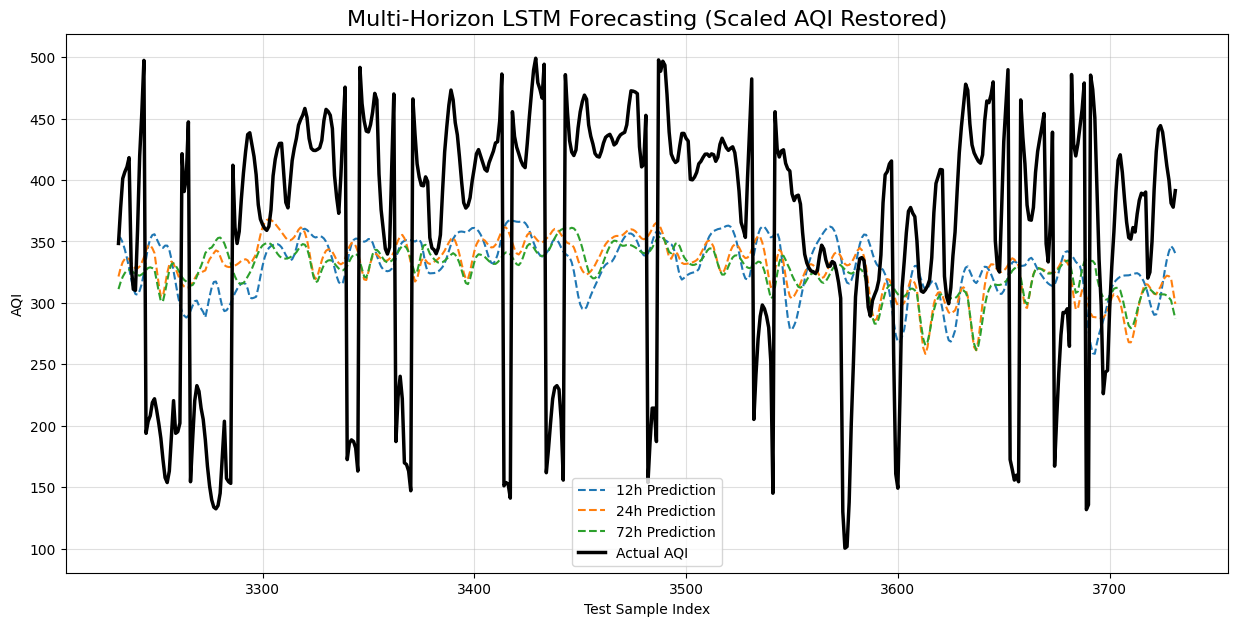

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
N_STEPS_IN = 48
TARGET_HORIZONS = [12, 24, 72]
#  AQI CALCULATION
def get_sub_index(c, i_high, i_low, c_high, c_low):
    if c >= c_low and c <= c_high and c_high != c_low:
        return ((i_high - i_low) / (c_high - c_low)) * (c - c_low) + i_low
    return None

def calculate_aqi(row):
    breakpoints_pm25 = [(0, 30, 0, 50), (30, 60, 50, 100), (60, 90, 100, 200),(90, 120, 200, 300), (120, 250, 300, 400), (250, 500, 400, 500)]
    breakpoints_co = [(0, 1, 0, 50), (1, 2, 50, 100), (2, 10, 100, 200),(10, 17, 200, 300), (17, 34, 300, 400), (34, 50, 400, 500)]
    pollutants = {'pm2_5': row['pm2_5'], 'co': row['co'] / 1000}
    sub_indices = []

    # PM2.5
    for cl, ch, il, ih in breakpoints_pm25:
        idx = get_sub_index(pollutants['pm2_5'], ih, il, ch, cl)
        if idx is not None:
            sub_indices.append(idx)
            break

    # CO
    for cl, ch, il, ih in breakpoints_co:
        idx = get_sub_index(pollutants['co'], ih, il, ch, cl)
        if idx is not None:
            sub_indices.append(idx)
            break

    return max(sub_indices) if sub_indices else np.nan

#  SEQUENCE BUILDER
def create_sequences(data, target_data, n_steps_in, target_horizons):
    X, y = [], []
    max_horizon = max(target_horizons)

    for i in range(len(data) - n_steps_in - max_horizon + 1):
        end_ix = i + n_steps_in
        X.append(data[i:end_ix, :])

        targets = []
        for h in target_horizons:
            targets.append(target_data[end_ix + h - 1])
        y.append(targets)

    return np.array(X), np.array(y)

# funciton to build model
def build_multi_output_lstm_model(n_steps_in, n_features, n_outputs):
    model = Sequential([
    Bidirectional(LSTM(128, activation=gelu, return_sequences=True), input_shape=(n_steps_in, n_features)),
    LSTM(64, activation=gelu),
    Dense(n_outputs)
])
    model.compile(optimizer=Adam(0.0005), loss='mse')
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model;


# Load and prepare the data for the bidirectional LSTM
df = pd.read_csv('delhi_aqi.csv')
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek / 7)
pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3', 'no', 'nh3']
temporal = ['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']
model_features = pollutants + temporal

for col in pollutants:
    df.loc[df[col] < 0, col] = np.nan

df = df.fillna(df.median(numeric_only=True))
df['Net_AQI'] = df.apply(calculate_aqi, axis=1)
df = df.dropna(subset=['Net_AQI'])

#scaling the inmput features using minima amd maxima of the field
feature_scaler = MinMaxScaler()
data_scaled = feature_scaler.fit_transform(df[model_features])
#Scaling the target variable
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(df[['Net_AQI']])
# Create Sequences
X, y = create_sequences(data_scaled, target_scaled, N_STEPS_IN, TARGET_HORIZONS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_multi_output_lstm_model(N_STEPS_IN, X.shape[2], len(TARGET_HORIZONS))
model.fit(X_train, y_train, epochs=15, batch_size=12, validation_split=0.1, verbose=1)

# PREDICT
y_pred = model.predict(X_test, verbose=0)
y_pred = target_scaler.inverse_transform(y_pred)
y_test = target_scaler.inverse_transform(y_test)

# Evaluation metrics and plotting of the data
print(" MULTI-HORIZON FORECAST PERFORMANCE")
for i, h in enumerate(TARGET_HORIZONS):
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"{h}h Ahead RMSE: {rmse} | R²: {r2}")

plt.figure(figsize=(15, 7))
idx = np.arange(len(y_test))[-500:]
for i, h in enumerate(TARGET_HORIZONS):
    plt.plot(idx, y_pred[-500:, i], linestyle='--', label=f"{h}h Prediction")
plt.plot(idx, y_test[-500:, 0], color='black', linewidth=2.5, label="Actual AQI")
plt.title("Multi-Horizon LSTM Forecasting (Scaled AQI Restored)", fontsize=16)
plt.xlabel("Test Sample Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


/tmp/ipython-input-2389204907.py:79: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


Data Ready. Total Flat Features: 576. Look-back: 48 hours.
Training Input Shape: (14973, 576)

--- Training XGBoost Regressor Model ---

--- Training Random Forest Regressor Model ---

--- Model Performance Summary (12h Forecast) ---
XGBoost         | RMSE: 105.4829 | R-squared: 0.4039
Random Forest   | RMSE: 106.3313 | R-squared: 0.3943
ENSEMBLE (Trad.) | RMSE: 105.2875 | R-squared: 0.4061


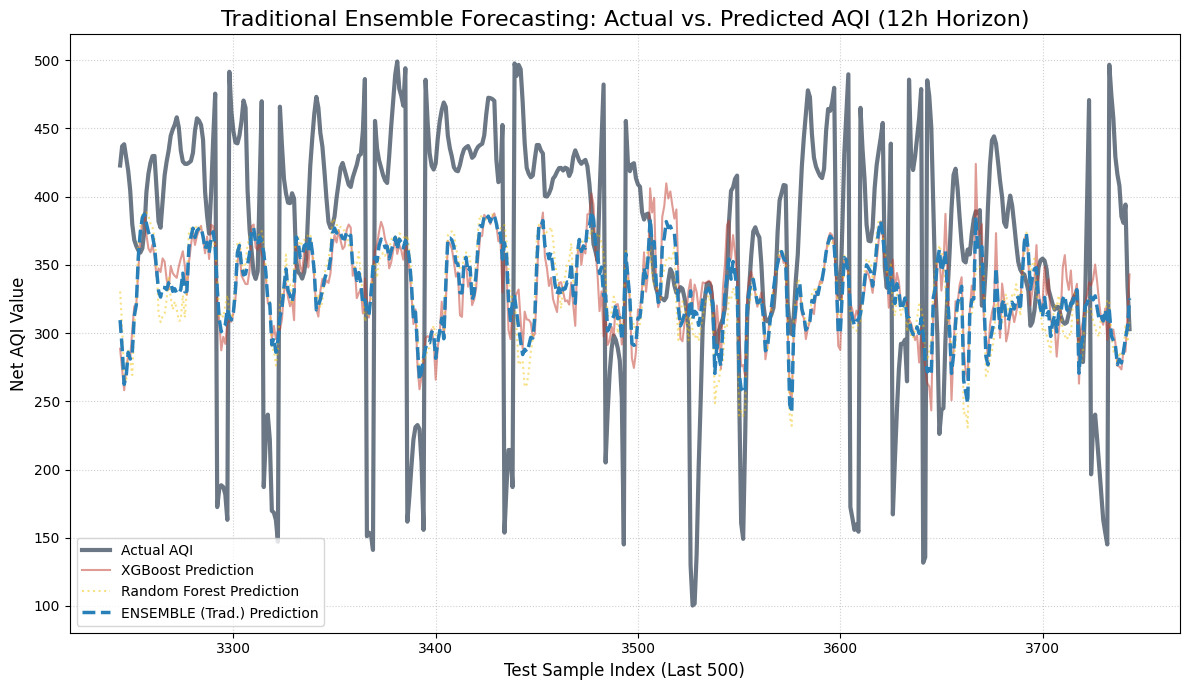

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

N_STEPS_IN = 48
TARGET_HORIZON = 12
ENSEMBLE_WEIGHTS = [0.5, 0.5]

def get_sub_index(c, i_high, i_low, c_high, c_low):
    if c >= c_low and c <= c_high and c_high != c_low:
        return ((i_high - i_low) / (c_high - c_low)) * (c - c_low) + i_low
    return None

def calculate_aqi(row):
    breakpoints_pm25 = [(0, 30, 0, 50), (30, 60, 50, 100), (60, 90, 100, 200), (90, 120, 200, 300), (120, 250, 300, 400), (250, 500, 400, 500)]
    breakpoints_co = [(0, 1, 0, 50), (1, 2, 50, 100), (2, 10, 100, 200), (10, 17, 200, 300), (17, 34, 300, 400), (34, 50, 400, 500)]
    pollutants = {'pm2_5': row['pm2_5'], 'co': row['co'] / 1000}
    sub_indices = []

    pm25_c = pollutants['pm2_5']
    for cl, ch, il, ih in breakpoints_pm25:
        idx = get_sub_index(pm25_c, ih, il, ch, cl)
        if idx is not None:
            sub_indices.append(idx)
            break

    co_c = pollutants['co']
    for cl, ch, il, ih in breakpoints_co:
        idx = get_sub_index(co_c, ih, il, ch, cl)
        if idx is not None:
            sub_indices.append(idx)
            break

    if not sub_indices:
        return np.nan
    return max(sub_indices)

def create_sequences_2d(data, target_data, n_steps_in, target_horizon):
    X, y = [], []

    for i in range(len(data) - n_steps_in - target_horizon + 1):
        end_ix = i + n_steps_in

        X.append(data[i:end_ix, :].flatten())

        target_ix = end_ix + target_horizon - 1
        y.append(target_data[target_ix])

    return np.array(X), np.array(y)

def build_xgb_model():
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        n_jobs=-1,
        random_state=42
    )
    return model

def build_rf_model():
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    )
    return model

try:
    df = pd.read_csv('delhi_aqi.csv')

    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour

    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24.0)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek/7.0)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek/7.0)

    pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3', 'no', 'nh3']
    temporal = ['hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']
    model_features = pollutants + temporal

    for col in pollutants:
        df.loc[df[col] < 0, col] = np.nan

    df = df.fillna(df.median(numeric_only=True))

    df['Net_AQI'] = df.apply(calculate_aqi, axis=1)
    df = df.dropna(subset=['Net_AQI'])

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df[model_features].values)
    target_data = df['Net_AQI'].values.ravel()

    N_FEATURES = data_scaled.shape[1]
    N_FEATURES_FLAT = N_FEATURES * N_STEPS_IN

    X_ensemble, y_target = create_sequences_2d(data_scaled, target_data, N_STEPS_IN, TARGET_HORIZON)

    test_size_ratio = 0.2

    X_train, X_test, y_train, y_test = train_test_split(
        X_ensemble, y_target, test_size=test_size_ratio, shuffle=False, random_state=42
    )

    print(f"Data Ready. Total Flat Features: {N_FEATURES_FLAT}. Look-back: {N_STEPS_IN} hours.")
    print(f"Training Input Shape: {X_train.shape}")

except FileNotFoundError:
    print("Error: 'delhi_aqi.csv' not found. Using dummy data for demonstration.")
    N_SAMPLES = 10000
    N_FEATURES = 12
    N_STEPS_IN = 48
    N_FEATURES_FLAT = N_FEATURES * N_STEPS_IN

    X_train = np.random.rand(int(N_SAMPLES*0.8), N_FEATURES_FLAT)
    X_test = np.random.rand(int(N_SAMPLES*0.2), N_FEATURES_FLAT)
    y_train = np.random.rand(int(N_SAMPLES*0.8),) * 300
    y_test = np.random.rand(int(N_SAMPLES*0.2),) * 300

print("\n--- Training XGBoost Regressor Model ---")
xgb_model = build_xgb_model()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n--- Training Random Forest Regressor Model ---")
rf_model = build_rf_model()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

w_xgb, w_rf = ENSEMBLE_WEIGHTS
y_pred_ensemble = (w_xgb * y_pred_xgb) + (w_rf * y_pred_rf)

def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<15} | RMSE: {rmse:.4f} | R-squared: {r2:.4f}")
    return rmse, r2

print(f"\n--- Model Performance Summary (12h Forecast) ---")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_ensemble, "ENSEMBLE (Trad.)")

plt.figure(figsize=(12, 7))
test_indices = np.arange(len(y_test))[-500:]

plt.plot(test_indices, y_test[-500:], label='Actual AQI', color='#2c3e50', linewidth=3, alpha=0.7)
plt.plot(test_indices, y_pred_xgb[-500:], label='XGBoost Prediction', color='#c0392b', linestyle='-', alpha=0.5)
plt.plot(test_indices, y_pred_rf[-500:], label='Random Forest Prediction', color='#f1c40f', linestyle=':', alpha=0.5)
plt.plot(test_indices, y_pred_ensemble[-500:], label='ENSEMBLE (Trad.) Prediction', color='#2980b9', linestyle='--', linewidth=2.5)

plt.title(f'Traditional Ensemble Forecasting: Actual vs. Predicted AQI ({TARGET_HORIZON}h Horizon)', fontsize=16)
plt.xlabel('Test Sample Index (Last 500)', fontsize=12)
plt.ylabel('Net AQI Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()